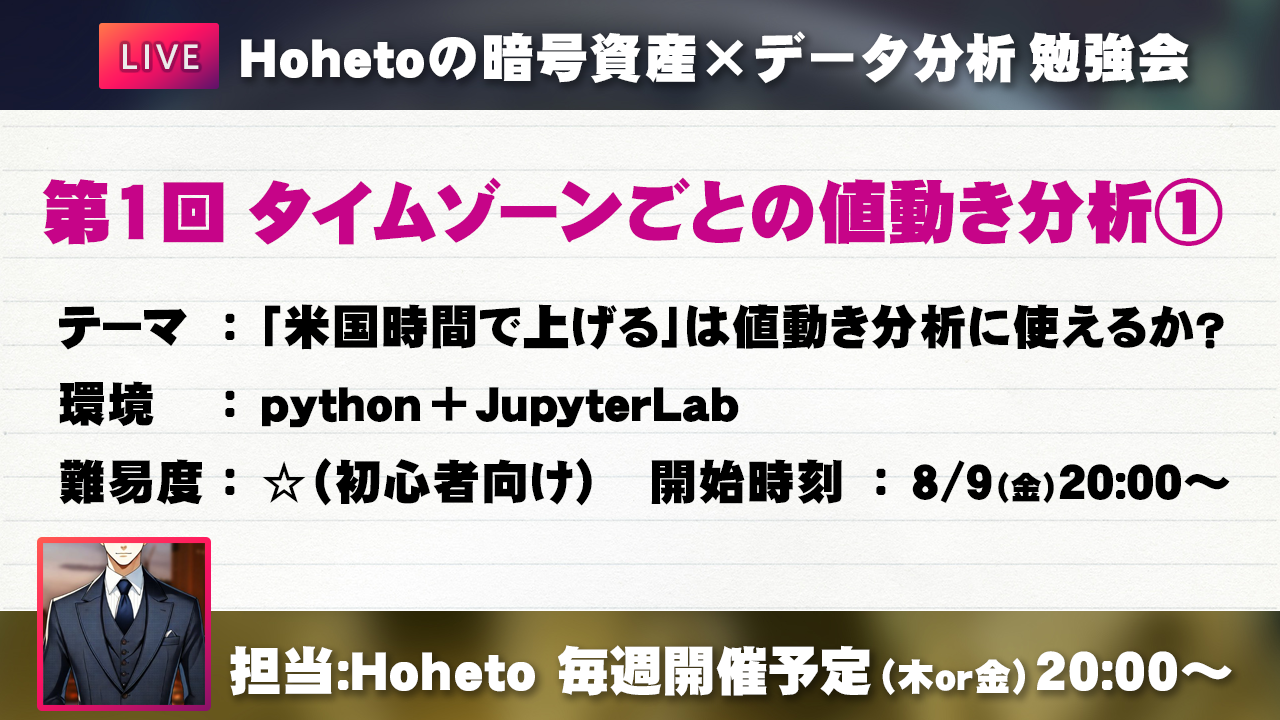

In [1]:
from IPython.display import Image

Image('./images/01_00.png')

# Hoheto勉強会 第1回 タイムゾーンごとの値動き分析①

- タイムゾーンごとの傾向をビットコインの値動き分析に活かすことはできるか？
- 例）「米国時間で上げやすい」 「日本時間で下げやすい」など
- 難易度 ☆

- DataFrameの基礎的な操作を使って、初歩的な分析を行っていきます。
- Xなどから仕入れたネタを検証する一連の流れを追っていきます。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 難易度

- ☆1つ。
- そこまで深入りせずにDataFrameの基礎的な操作と可視化を中心に行います。

## コンセプト

- ビットコインは「米国時間で強い」、「アジア時間で強い」と言われることがある。
- 常に強いわけではなく、時期的なもの。「最近米国時間で上げることが多い」というような文脈をたまに見かける。
- この傾向は顕著なのか（統計的に有意なのか）？再現性はあるのか？

### 元ネタ

- Xはネタの宝庫。

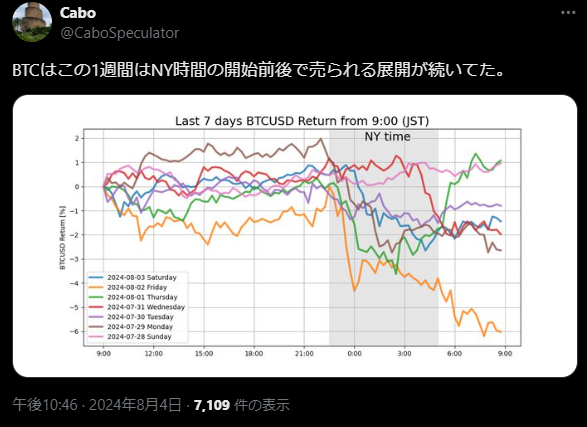

In [2]:
# https://twitter.com/CaboSpeculator/status/1820093847218843924
Image('./images/01_01.png')

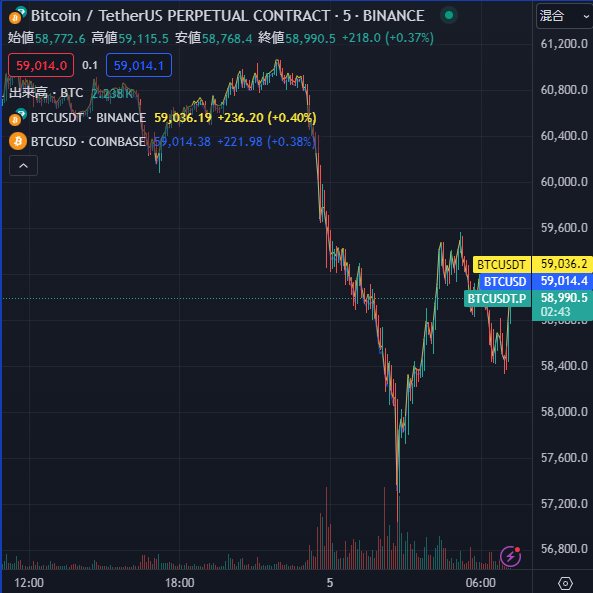

In [3]:
# 翌8/5 早朝 下落.
Image('./images/01_02.png')

## 米国時間とは

- 日本時間で23：30～翌朝6：00
- サマータイムでは22：30～翌朝5：00
  - 2024年3月10日日曜日 ～ 2024年11月3日日曜日
  - 毎年3月第2日曜日～11月第1日曜日の期間がサマータイム
- 詳しくは後述

## 環境設定


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import japanize_matplotlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import requests
import time
import traceback
import warnings

from datetime import datetime
from IPython.display import display, Image
from scipy import stats
from tqdm import tqdm

In [6]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# データ取得～整備

## Binance USDM 5分足取得

- Binanceの無期限先物。
- BTCUSDTPERPのデータ（2019年9月～直近）。
- Binanceの公式APIですべて取得可能。今回はあらかじめ取得したデータを使います。

In [7]:
import pickle

def load_pickle(path):
    with open(path, mode="rb") as f:
        data = pickle.load(f)
        return data

※エラーが出る場合pandasのバージョン違いの可能性. pandas==2.2.2

In [8]:
candles_org = load_pickle('./data/01_candles_org.pkl')

In [9]:
candles_org

,open_price,high_price,low_price,close_price,volume,quote_volume,trade_num,buy_volume,quote_buy_volume,symbol,source
dt,,,,,,,,,,,
2019-09-08 17:55:00+00:00,10000.0,10000.0,10000.0,10000.0,0.002,2.000000e+01,2.0,0.001,1.000000e+01,BTCUSDT,binance_usdm
2019-09-08 18:00:00+00:00,10000.0,10000.0,10000.0,10000.0,0.000,0.000000e+00,0.0,0.000,0.000000e+00,BTCUSDT,binance_usdm
2019-09-08 18:05:00+00:00,10000.0,10000.0,10000.0,10000.0,0.000,0.000000e+00,0.0,0.000,0.000000e+00,BTCUSDT,binance_usdm
2019-09-08 18:10:00+00:00,10000.0,10000.0,10000.0,10000.0,0.000,0.000000e+00,0.0,0.000,0.000000e+00,BTCUSDT,binance_usdm
2019-09-08 18:15:00+00:00,10000.0,10000.0,10000.0,10000.0,0.000,0.000000e+00,0.0,0.000,0.000000e+00,BTCUSDT,binance_usdm
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-08 23:35:00+00:00,61848.2,61930.1,61714.5,61853.4,1918.554,1.186133e+08,23425.0,1069.148,6.610511e+07,BTCUSDT,binance_usdm
2024-08-08 23:40:00+00:00,61851.8,62070.9,61843.6,61924.4,1542.919,9.558234e+07,19011.0,965.120,5.979361e+07,BTCUSDT,binance_usdm
2024-08-08 23:45:00+00:00,61924.4,61928.5,61733.3,61756.7,1499.442,9.266975e+07,16915.0,463.415,2.864228e+07,BTCUSDT,binance_usdm


## データチェック

- 第一回目なので少し丁寧に説明します。

### 欠損値チェック

- 欠損値（NaN）が含まれているデータの有無をチェックします。

In [10]:
candles_org.isnull().any()

open_price          False
high_price          False
low_price           False
close_price         False
volume              False
quote_volume        False
trade_num           False
buy_volume          False
quote_buy_volume    False
symbol              False
source              False
dtype: bool

### 統計量チェック

- データの範囲に不自然な箇所がないかチェックします。

In [11]:
candles_org.describe()

,open_price,high_price,low_price,close_price,volume,quote_volume,trade_num,buy_volume,quote_buy_volume
count,517321.000000,517321.000000,517321.000000,517321.000000,517321.000000,5.173210e+05,517321.000000,517321.000000,5.173210e+05
mean,31376.692115,31417.504819,31335.415697,31376.791718,1259.031788,3.938259e+07,10177.175189,627.587776,1.959772e+07
std,18348.432463,18373.160572,18323.301794,18348.455917,1968.771525,6.424541e+07,13488.931625,998.709161,3.242267e+07
min,3757.750000,3920.000000,3621.810000,3761.100000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,16577.900000,16589.900000,16566.800000,16578.000000,373.803000,8.447873e+06,3097.000000,177.863000,4.017535e+06
50%,28594.400000,28629.900000,28562.300000,28594.500000,704.439000,2.124116e+07,6549.000000,344.731000,1.031054e+07
75%,43934.900000,43980.000000,43885.300000,43934.900000,1383.661000,4.522014e+07,12153.000000,691.072000,2.243623e+07
max,73698.500000,73881.400000,73641.500000,73698.500000,86782.489000,2.816829e+09,654538.000000,52976.379000,1.621367e+09


### 抜け漏れチェック

In [12]:
tmp = candles_org.copy()
tmp['ts'] = tmp.index.astype(np.int64) / 10**6
tmp['ts_diff'] = tmp['ts'].diff()
tmp[tmp['ts_diff'] != 300]

,open_price,high_price,low_price,close_price,volume,quote_volume,trade_num,buy_volume,quote_buy_volume,symbol,source,ts,ts_diff
dt,,,,,,,,,,,,,
2019-09-08 17:55:00+00:00,10000.0,10000.0,10000.0,10000.0,0.002,20.0,2.0,0.001,10.0,BTCUSDT,binance_usdm,1.567965e+09,NaN


### 最初のあたりのデータチェック

- BTCUSDTがリスティングされたときの挙動がおかしい。
- 2019/9/10以降を使う

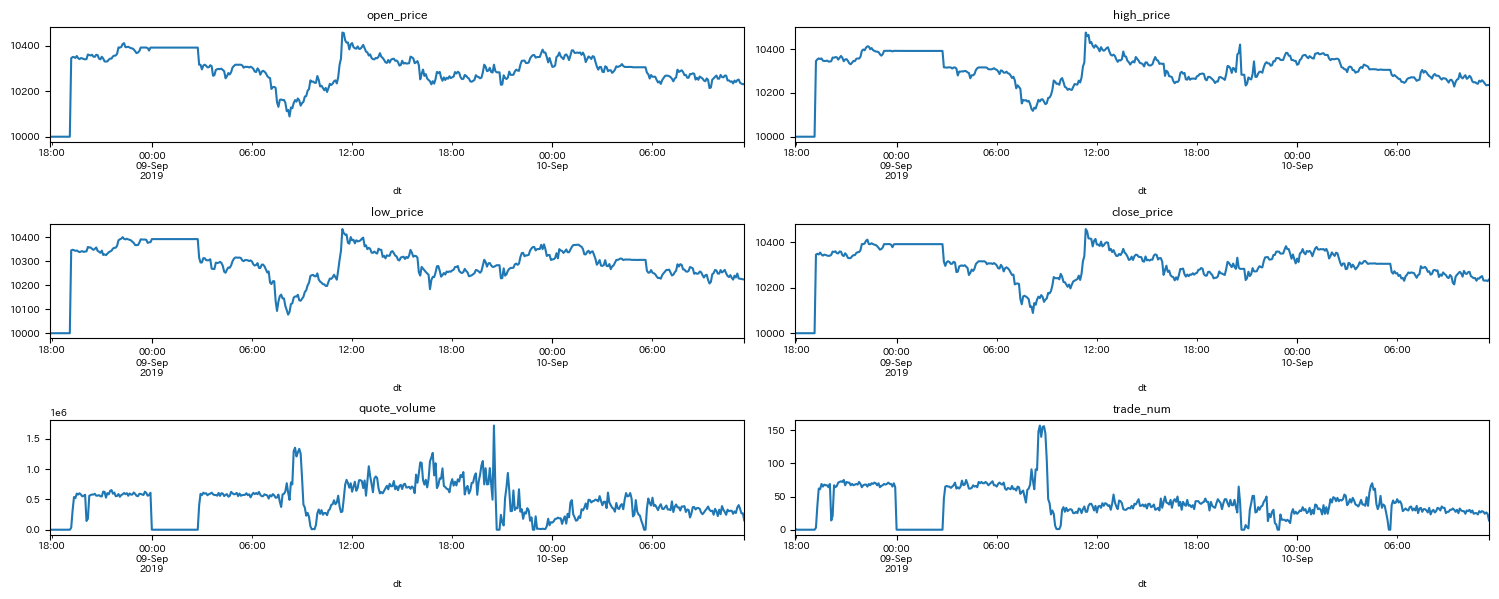

In [13]:
fig = plt.figure(figsize=(15, 6))
for i, feature in enumerate(['open_price', 'high_price', 'low_price', 'close_price', 'quote_volume', 'trade_num']):
    ax = plt.subplot(3, 2, i+1)
    ax.set_title(feature)
    candles_org[feature].head(500).plot(ax=ax)
plt.tight_layout();

In [14]:
candles = candles_org['2019-09-10':]

In [15]:
candles

,open_price,high_price,low_price,close_price,volume,quote_volume,trade_num,buy_volume,quote_buy_volume,symbol,source
dt,,,,,,,,,,,
2019-09-10 00:00:00+00:00,10307.00,10328.27,10307.00,10328.27,11.372,1.173712e+05,24.0,7.709,7.961664e+04,BTCUSDT,binance_usdm
2019-09-10 00:05:00+00:00,10307.95,10331.80,10307.95,10313.00,13.581,1.402537e+05,26.0,11.470,1.184837e+05,BTCUSDT,binance_usdm
2019-09-10 00:10:00+00:00,10313.00,10350.52,10313.00,10350.52,17.266,1.786155e+05,29.0,15.274,1.580448e+05,BTCUSDT,binance_usdm
2019-09-10 00:15:00+00:00,10350.52,10355.60,10332.96,10355.60,17.538,1.815683e+05,28.0,17.533,1.815167e+05,BTCUSDT,binance_usdm
2019-09-10 00:20:00+00:00,10355.60,10369.93,10311.52,10369.93,19.287,1.995639e+05,34.0,18.296,1.893276e+05,BTCUSDT,binance_usdm
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-08 23:35:00+00:00,61848.20,61930.10,61714.50,61853.40,1918.554,1.186133e+08,23425.0,1069.148,6.610511e+07,BTCUSDT,binance_usdm
2024-08-08 23:40:00+00:00,61851.80,62070.90,61843.60,61924.40,1542.919,9.558234e+07,19011.0,965.120,5.979361e+07,BTCUSDT,binance_usdm
2024-08-08 23:45:00+00:00,61924.40,61928.50,61733.30,61756.70,1499.442,9.266975e+07,16915.0,463.415,2.864228e+07,BTCUSDT,binance_usdm


## データチェックのポイントまとめ

- 必ず欠損値の状況をチェックする。
- 必ずデータの統計量、つまり分布をチェックする。
- 必ずデータの抜け漏れをチェックする。

## 日足の作成

In [16]:
candles_1d = candles.resample('1d').agg({
    'open_price': 'first',
    'high_price': 'max',
    'low_price': 'min',
    'close_price': 'last',
})

In [17]:
candles_1d

,open_price,high_price,low_price,close_price
dt,,,,
2019-09-10 00:00:00+00:00,10307.00,10382.97,9940.87,10102.02
2019-09-11 00:00:00+00:00,10094.27,10293.11,9884.31,10159.55
2019-09-12 00:00:00+00:00,10163.06,10450.13,10042.12,10415.13
2019-09-13 00:00:00+00:00,10414.96,10440.55,10153.51,10341.34
2019-09-14 00:00:00+00:00,10343.01,10419.97,10222.77,10332.25
...,...,...,...,...
2024-08-04 00:00:00+00:00,60684.50,61089.50,57040.00,58144.50
2024-08-05 00:00:00+00:00,58144.50,58286.90,48888.00,54003.10
2024-08-06 00:00:00+00:00,54003.50,56999.90,53925.30,55991.20


### 日次リターン

In [18]:
candles_1d['ret'] = (candles_1d['close_price'] - candles_1d['open_price']) / candles_1d['open_price']

In [19]:
candles_1d

,open_price,high_price,low_price,close_price,ret
dt,,,,,
2019-09-10 00:00:00+00:00,10307.00,10382.97,9940.87,10102.02,-0.019887
2019-09-11 00:00:00+00:00,10094.27,10293.11,9884.31,10159.55,0.006467
2019-09-12 00:00:00+00:00,10163.06,10450.13,10042.12,10415.13,0.024803
2019-09-13 00:00:00+00:00,10414.96,10440.55,10153.51,10341.34,-0.007069
2019-09-14 00:00:00+00:00,10343.01,10419.97,10222.77,10332.25,-0.001040
...,...,...,...,...,...
2024-08-04 00:00:00+00:00,60684.50,61089.50,57040.00,58144.50,-0.041856
2024-08-05 00:00:00+00:00,58144.50,58286.90,48888.00,54003.10,-0.071226
2024-08-06 00:00:00+00:00,54003.50,56999.90,53925.30,55991.20,0.036807


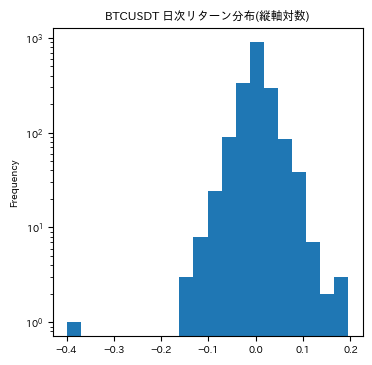

In [20]:
plt.title('BTCUSDT 日次リターン分布(縦軸対数)')
candles_1d['ret'].plot(kind='hist', bins=20)
plt.yscale('log');

## 米国時間の日足作成

### おさらい 米国時間とは

- 米国の株式市場の取引時間
  - 標準時間：
    - 米東部標準時（EST）：午前9時30分から午後4時まで
    - 日本時間（JST）：午後11時30分から翌朝6時まで
  - サマータイム：
    - 米東部夏時間（EDT）：午前9時30分から午後4時まで
    - 日本時間（JST）：午後10時30分から翌朝5時まで
- 米国のサマータイムの概要
  - 毎年3月第2日曜日～11月第1日曜日の期間がサマータイム
  - 2024年は、3月10日（日） ～ 11月3日（日）
  - 午前2時（標準時間）に時計を1時間進めて午前3時にする。
  - サマータイム終了時には、午前2時（サマータイム）に時計を1時間戻して午前1時にする。

In [21]:
candles_us = candles.copy()
candles_us.index = candles_us.index.tz_convert('America/New_York')

- timezoneを設定すると、サマータイムを勝手に計算してくれる！

In [22]:
candles_us

,open_price,high_price,low_price,close_price,volume,quote_volume,trade_num,buy_volume,quote_buy_volume,symbol,source
dt,,,,,,,,,,,
2019-09-09 20:00:00-04:00,10307.00,10328.27,10307.00,10328.27,11.372,1.173712e+05,24.0,7.709,7.961664e+04,BTCUSDT,binance_usdm
2019-09-09 20:05:00-04:00,10307.95,10331.80,10307.95,10313.00,13.581,1.402537e+05,26.0,11.470,1.184837e+05,BTCUSDT,binance_usdm
2019-09-09 20:10:00-04:00,10313.00,10350.52,10313.00,10350.52,17.266,1.786155e+05,29.0,15.274,1.580448e+05,BTCUSDT,binance_usdm
2019-09-09 20:15:00-04:00,10350.52,10355.60,10332.96,10355.60,17.538,1.815683e+05,28.0,17.533,1.815167e+05,BTCUSDT,binance_usdm
2019-09-09 20:20:00-04:00,10355.60,10369.93,10311.52,10369.93,19.287,1.995639e+05,34.0,18.296,1.893276e+05,BTCUSDT,binance_usdm
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-08 19:35:00-04:00,61848.20,61930.10,61714.50,61853.40,1918.554,1.186133e+08,23425.0,1069.148,6.610511e+07,BTCUSDT,binance_usdm
2024-08-08 19:40:00-04:00,61851.80,62070.90,61843.60,61924.40,1542.919,9.558234e+07,19011.0,965.120,5.979361e+07,BTCUSDT,binance_usdm
2024-08-08 19:45:00-04:00,61924.40,61928.50,61733.30,61756.70,1499.442,9.266975e+07,16915.0,463.415,2.864228e+07,BTCUSDT,binance_usdm


In [23]:
candles_us['2024-03-10 01:50':'2024-03-10 03:10']

,open_price,high_price,low_price,close_price,volume,quote_volume,trade_num,buy_volume,quote_buy_volume,symbol,source
dt,,,,,,,,,,,
2024-03-10 01:50:00-05:00,69348.9,69433.8,69315.0,69419.1,276.993,1.922106e+07,5441.0,177.848,1.234177e+07,BTCUSDT,binance_usdm
2024-03-10 01:55:00-05:00,69419.1,69430.0,69390.3,69405.8,218.046,1.513398e+07,4226.0,101.633,7.053993e+06,BTCUSDT,binance_usdm
2024-03-10 03:00:00-04:00,69405.7,69468.5,69374.6,69436.0,565.130,3.923228e+07,6634.0,382.932,2.658310e+07,BTCUSDT,binance_usdm
2024-03-10 03:05:00-04:00,69436.0,69448.2,69388.9,69393.5,331.385,2.300668e+07,5985.0,134.453,9.334902e+06,BTCUSDT,binance_usdm
2024-03-10 03:10:00-04:00,69393.5,69413.1,69368.6,69382.9,217.856,1.511663e+07,4495.0,86.139,5.977031e+06,BTCUSDT,binance_usdm


### 米国時間だけを抽出

In [24]:
candles_us = candles_us.iloc[candles_us.index.indexer_between_time('09:30', '16:00')]

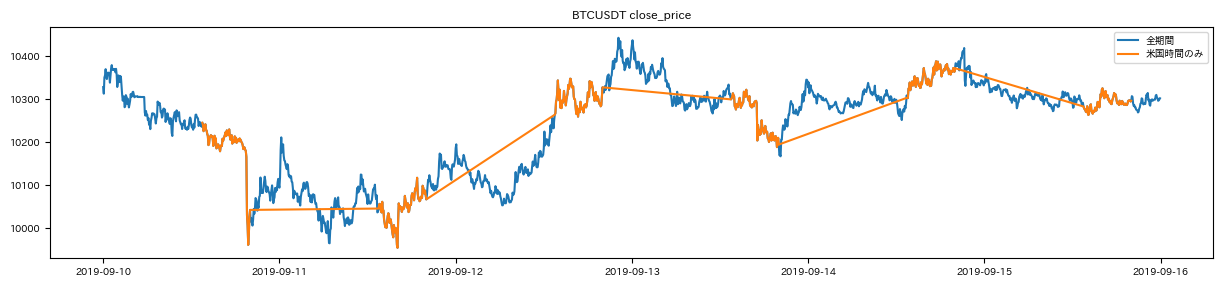

In [25]:
fig = plt.figure(figsize=(15, 3))
plt.title('BTCUSDT close_price')
plt.plot(candles[:'2019-09-15']['close_price'], label='全期間')
plt.plot(candles_us[:'2019-09-15']['close_price'], label='米国時間のみ')
plt.legend();

### 日足を作成

In [26]:
candles_1d_us = candles_us.resample('1d').agg({
    'open_price': 'first',
    'high_price': 'max',
    'low_price': 'min',
    'close_price': 'last'
})

In [27]:
candles_1d_us

,open_price,high_price,low_price,close_price
dt,,,,
2019-09-10 00:00:00-04:00,10234.99,10248.23,9940.87,10042.67
2019-09-11 00:00:00-04:00,10028.54,10123.29,9934.11,10067.14
2019-09-12 00:00:00-04:00,10251.10,10365.15,10239.42,10327.75
2019-09-13 00:00:00-04:00,10303.47,10326.46,10186.34,10194.67
2019-09-14 00:00:00-04:00,10306.39,10398.00,10294.23,10372.21
...,...,...,...,...
2024-08-04 00:00:00-04:00,60876.00,60945.20,57040.00,59302.30
2024-08-05 00:00:00-04:00,49715.00,55523.00,49600.00,53760.90
2024-08-06 00:00:00-04:00,55124.50,56999.90,54393.40,56400.10


### 日次リターン

In [28]:
candles_1d_us['ret'] = (candles_1d_us['close_price'] - candles_1d_us['open_price']) / candles_1d_us['open_price']

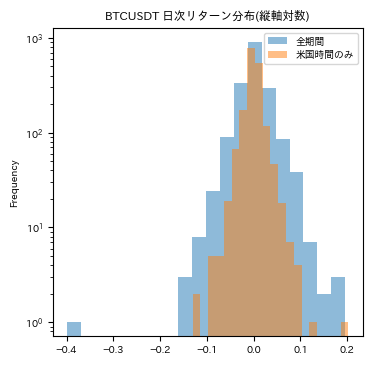

In [29]:
plt.title('BTCUSDT 日次リターン分布(縦軸対数)')
candles_1d['ret'].plot(kind='hist', alpha=0.5, label='全期間', bins=20)
candles_1d_us['ret'].plot(kind='hist', alpha=0.5, label='米国時間のみ', bins=20)
plt.yscale('log')
plt.legend();

# 検証内容の検討

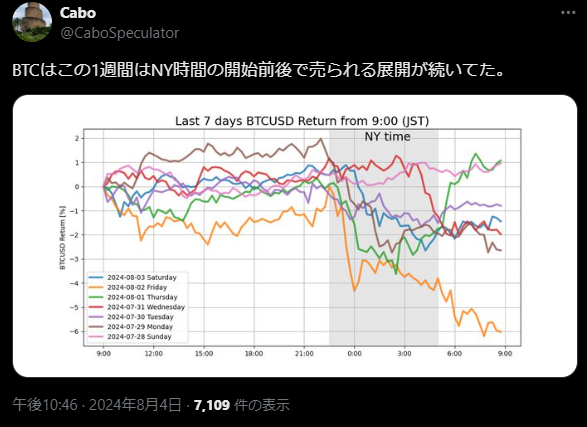

In [30]:
# https://twitter.com/CaboSpeculator/status/1820093847218843924
Image('./images/01_01.png')

- 仮説1) 米国時間で上昇（下落）傾向が続けば、翌日も上昇（下落）しやすい
- 仮説2) 米国時間の開始前後で上昇（下落）傾向が続けば、翌日も上昇（下落）しやすい

# 検証1. 米国時間で上昇（下落）傾向が続けば、翌日も上昇（下落）しやすい

In [31]:
strategy1 = candles_1d_us.copy()

## リターンの符号（上昇なら1、下落なら-1）を総和

- そもそも上昇（下落）の傾向をどう表現するか？
  - とりあえず、リターンの符号を1週間分足し合わせてみる。

In [32]:
strategy1['ret_sign'] = np.sign(strategy1['ret'])
strategy1['ret_sign_sum7_s1'] = strategy1['ret_sign'].rolling(7).sum().shift(1)

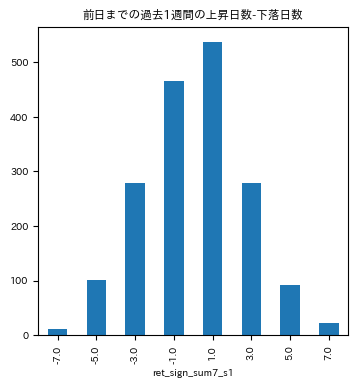

In [33]:
plt.title('前日までの過去1週間の上昇日数-下落日数')
strategy1.groupby('ret_sign_sum7_s1').size().plot(kind='bar');

- A群：上昇日数-下落日数が-3以下
- B群：その間
- C群：上昇日数-下落日数が+3以上

## 各グループの分布を確認

In [34]:
ret_a = strategy1.query('ret_sign_sum7_s1 <= -3')['ret']
ret_b = strategy1.query('-3 < ret_sign_sum7_s1 < 3')['ret']
ret_c = strategy1.query('ret_sign_sum7_s1 >= 3')['ret']

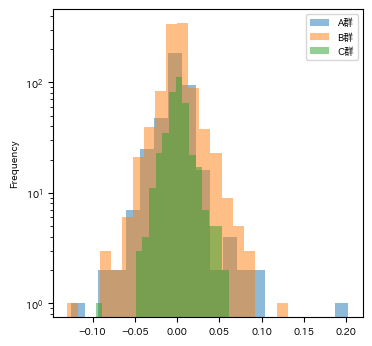

In [35]:
kwargs = {'kind': 'hist', 'bins': 20, 'alpha': 0.5}
ret_a.plot(label='A群', **kwargs)
ret_b.plot(label='B群', **kwargs)
ret_c.plot(label='C群', **kwargs)
plt.yscale('log')
plt.legend();

## Mann-Whitney検定

- 各グループの分布に有意差なし。

In [36]:
# MW検定
print('MW検定のp値')
u_stat, p_value = stats.mannwhitneyu(ret_a, ret_b)
print(f'A群とB群: {p_value:.4f}')
u_stat, p_value = stats.mannwhitneyu(ret_b, ret_c)
print(f'B群とC群: {p_value:.4f}')
u_stat, p_value = stats.mannwhitneyu(ret_a, ret_c)
print(f'A群とC群: {p_value:.4f}')

MW検定のp値
A群とB群: 0.2588
B群とC群: 0.7755
A群とC群: 0.2267


## 戦略1（損益曲線はあくまで参考）

- 戦略1 米国時間において、
  - 過去7日間の上昇日数-下落日数 >= 3 でロング
  - 過去7日間の上昇日数-下落日数 <= -3 でショート
  - それ以外はノーポジ

In [37]:
strategy1['signal'] = 0
strategy1.loc[strategy1['ret_sign_sum7_s1'] >= 3, 'signal'] = 1
strategy1.loc[strategy1['ret_sign_sum7_s1'] <= -3, 'signal'] = -1

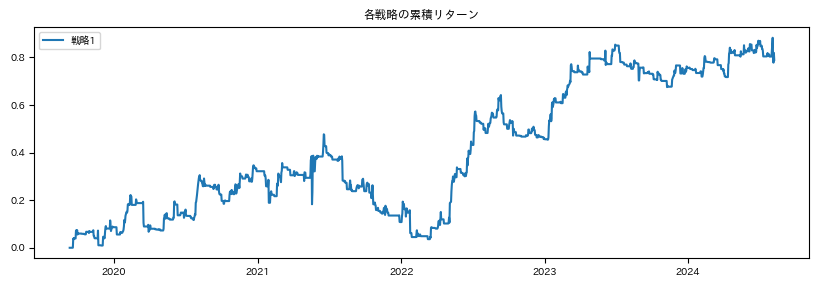

In [38]:
fig = plt.figure(figsize=(10, 3))
plt.title(f"各戦略の累積リターン")
plt.plot((strategy1['signal'] * strategy1['ret']).cumsum(), label='戦略1')
plt.legend();

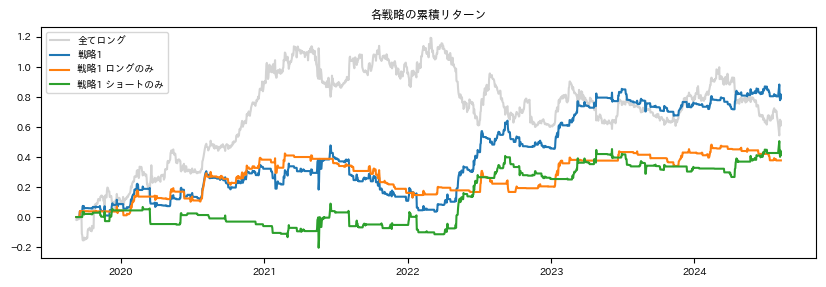

In [39]:
fig = plt.figure(figsize=(10, 3))
plt.title(f"各戦略の累積リターン")
plt.plot(strategy1['ret'].cumsum(), label='全てロング', c='lightgray')
plt.plot((strategy1['signal'] * strategy1['ret']).cumsum(), label='戦略1')
plt.plot((strategy1['signal'].replace(-1, 0) * strategy1['ret']).cumsum(), label='戦略1 ロングのみ')
plt.plot((strategy1['signal'].replace(1, 0) * strategy1['ret']).cumsum(), label='戦略1 ショートのみ')
plt.legend();

### 戦略1のロングの優位性

- ランダムで期間をピックアップしてロングしたときとの比較

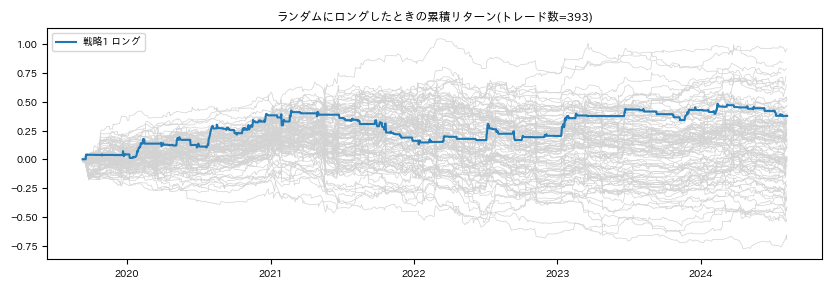

In [40]:
fig = plt.figure(figsize=(10, 3))
strategy1['signal'] = 0
strategy1.loc[strategy1['ret_sign_sum7_s1'] >= 3, 'signal'] = 1
trade_num = len(strategy1[strategy1['signal'] != 0])
plt.title(f"ランダムにロングしたときの累積リターン(トレード数={trade_num})")
for i in range(100):
    plt.plot(strategy1.sample(n=trade_num, random_state=i).sort_index()['ret'].cumsum(), color='lightgray', linewidth=0.5)

plt.plot((strategy1['signal'] * strategy1['ret']).cumsum(), label='戦略1 ロング')
plt.legend();

### 戦略1のショートの優位性

- ランダムで期間をピックアップしてショートしたときとの比較

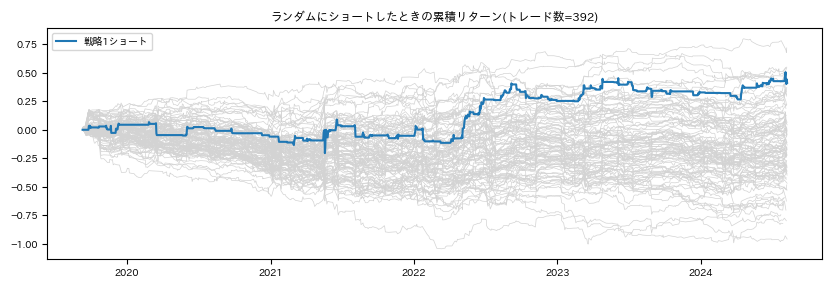

In [41]:
fig = plt.figure(figsize=(10, 3))
strategy1['signal'] = 0
strategy1.loc[strategy1['ret_sign_sum7_s1'] <= -3, 'signal'] = -1
trade_num = len(strategy1[strategy1['signal'] != 0])
plt.title(f"ランダムにショートしたときの累積リターン(トレード数={trade_num})")
for i in range(100):
    plt.plot(-strategy1.sample(n=trade_num, random_state=i).sort_index()['ret'].cumsum(), color='lightgray', linewidth=0.5)

plt.plot((strategy1['signal'] * strategy1['ret']).cumsum(), label='戦略1ショート')
plt.legend();

# 検証2. 米国の開始前後で上昇（下落）傾向が続けば、翌日も上昇（下落）しやすい

## 米国の開始前後（09:00～11:00）のデータを作成

In [42]:
candles_us_open = candles.copy()
candles_us_open.index = candles_us_open.index.tz_convert('America/New_York')
candles_us_open = candles_us_open.iloc[candles_us_open.index.indexer_between_time('09:00', '10:59')]
tmp = candles_us_open.resample('1d')
candles_us_open = pd.concat([
    tmp['open_price'].first(),
    tmp['high_price'].max(),
    tmp['low_price'].min(),
    tmp['close_price'].last(),
], axis=1)
candles_us_open['ret_1hour'] = (candles_us_open['close_price'] - candles_us_open['open_price']) / candles_us_open['open_price']

In [43]:
candles_us_open

,open_price,high_price,low_price,close_price,ret_1hour
dt,,,,,
2019-09-10 00:00:00-04:00,10256.66,10258.78,10176.69,10208.34,-0.004711
2019-09-11 00:00:00-04:00,10096.00,10101.38,9986.65,10030.18,-0.006519
2019-09-12 00:00:00-04:00,10235.34,10360.13,10219.15,10305.07,0.006813
2019-09-13 00:00:00-04:00,10324.82,10336.11,10270.00,10286.20,-0.003741
2019-09-14 00:00:00-04:00,10268.69,10357.83,10267.70,10348.72,0.007794
...,...,...,...,...,...
2024-08-04 00:00:00-04:00,61032.00,61057.10,59255.80,59564.00,-0.024053
2024-08-05 00:00:00-04:00,49788.40,54489.50,49570.30,54028.30,0.085158
2024-08-06 00:00:00-04:00,54752.60,56599.00,54288.00,56095.60,0.024529


In [44]:
strategy2 = candles_1d_us.copy()
strategy2['ret_1hour'] = candles_us_open['ret_1hour']

In [45]:
strategy2

,open_price,high_price,low_price,close_price,ret,ret_1hour
dt,,,,,,
2019-09-10 00:00:00-04:00,10234.99,10248.23,9940.87,10042.67,-0.018790,-0.004711
2019-09-11 00:00:00-04:00,10028.54,10123.29,9934.11,10067.14,0.003849,-0.006519
2019-09-12 00:00:00-04:00,10251.10,10365.15,10239.42,10327.75,0.007477,0.006813
2019-09-13 00:00:00-04:00,10303.47,10326.46,10186.34,10194.67,-0.010560,-0.003741
2019-09-14 00:00:00-04:00,10306.39,10398.00,10294.23,10372.21,0.006386,0.007794
...,...,...,...,...,...,...
2024-08-04 00:00:00-04:00,60876.00,60945.20,57040.00,59302.30,-0.025851,-0.024053
2024-08-05 00:00:00-04:00,49715.00,55523.00,49600.00,53760.90,0.081382,0.085158
2024-08-06 00:00:00-04:00,55124.50,56999.90,54393.40,56400.10,0.023140,0.024529


## リターンの符号（上昇なら1、下落なら-1）を総和

In [46]:
strategy2['ret_sign'] = np.sign(strategy2['ret_1hour'])
strategy2['ret_sign_sum7_s1'] = strategy2['ret_sign'].rolling(7).sum().shift(1)

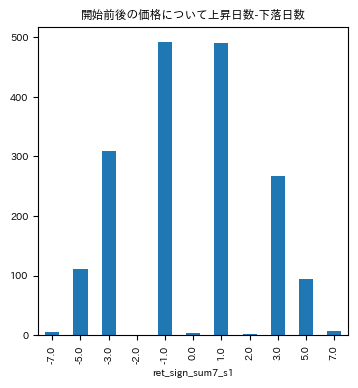

In [47]:
plt.title('開始前後の価格について上昇日数-下落日数')
strategy2.groupby('ret_sign_sum7_s1').size().plot(kind='bar');

- A群：上昇日数-下落日数が-3以下
- B群：その間
- C群：上昇日数-下落日数が+3以上

## 各グループの分布を確認

In [48]:
ret_a = strategy2.query('ret_sign_sum7_s1 <= -3')['ret']
ret_b = strategy2.query('-3 < ret_sign_sum7_s1 < 3')['ret']
ret_c = strategy2.query('ret_sign_sum7_s1 >= 3')['ret']

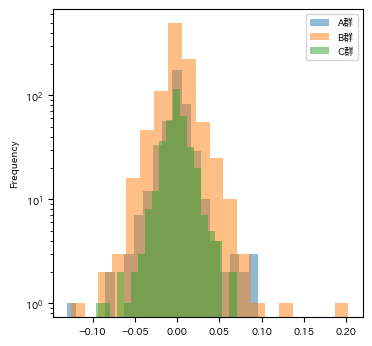

In [49]:
kwargs = {'kind': 'hist', 'bins': 20, 'alpha': 0.5}
ret_a.plot(label='A群', **kwargs)
ret_b.plot(label='B群', **kwargs)
ret_c.plot(label='C群', **kwargs)
plt.yscale('log')
plt.legend();

## Mann-Whitney検定

- 各グループの分布に有意差なし。

In [50]:
# MW検定
print('MWM検定のp値')
u_stat, p_value = stats.mannwhitneyu(ret_a, ret_b)
print(f'A群とB群: {p_value:.4f}')
u_stat, p_value = stats.mannwhitneyu(ret_b, ret_c)
print(f'B群とC群: {p_value:.4f}')
u_stat, p_value = stats.mannwhitneyu(ret_a, ret_c)
print(f'A群とC群: {p_value:.4f}')

MWM検定のp値
A群とB群: 0.6218
B群とC群: 0.2483
A群とC群: 0.5175


## 戦略2（損益曲線はあくまで参考）

- 戦略2 米国時間において、
  - 過去7日間について、開始前後の価格が上昇した日数-下落した日数 >= 3 でロング
  - 過去7日間について、開始前後の価格が上昇した日数-下落した日数 <= -3 でショート
  - それ以外はノーポジ

In [51]:
strategy2['signal'] = 0
strategy2.loc[strategy2['ret_sign_sum7_s1'] >= 3, 'signal'] = 1
strategy2.loc[strategy2['ret_sign_sum7_s1'] <= -3, 'signal'] = -1

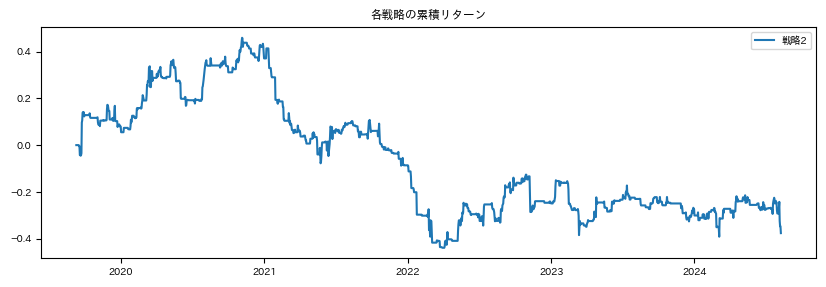

In [52]:
fig = plt.figure(figsize=(10, 3))
plt.title(f"各戦略の累積リターン")
plt.plot((strategy2['signal'] * strategy2['ret']).cumsum(), label='戦略2')
plt.legend();

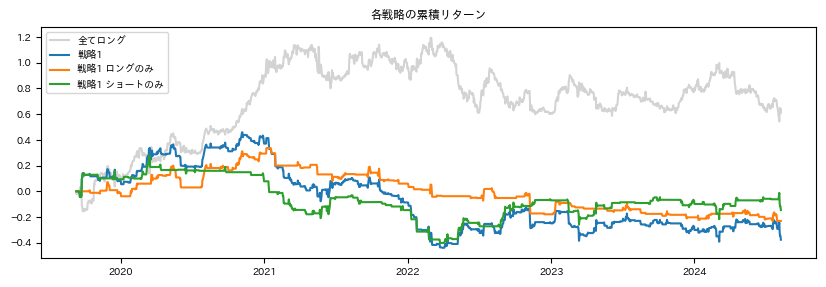

In [53]:
fig = plt.figure(figsize=(10, 3))
plt.title(f"各戦略の累積リターン")
plt.plot(strategy2['ret'].cumsum(), label='全てロング', c='lightgray')
plt.plot((strategy2['signal'] * strategy2['ret']).cumsum(), label='戦略1')
plt.plot((strategy2['signal'].replace(-1, 0) * strategy2['ret']).cumsum(), label='戦略1 ロングのみ')
plt.plot((strategy2['signal'].replace(1, 0) * strategy2['ret']).cumsum(), label='戦略1 ショートのみ')
plt.legend();

# まとめ

## 考察

- 「米国時間で上げる」は値動き分析に使えるか？ → 今回の検証の中では、使えるとは言えない（あくまで「今回の検証の中では」。また、活かせないとは言ってない）。
- 掘り下げるとしたら、下落時を掘り下げたい。
- 上記の戦略は典型的なトレンド系のテクニカルであるが、思ったよりは効いた。損益曲線はあくまで参考に。

## 今後

- 今回は米国時間の中で完結させたが、他のタイムゾーンとの兼ね合いは？
- 他の時間帯との相対的な強弱で調べるのはどうか？
- 日中の値動きは関係あるか？ など

一歩踏み込んで

- 米国時間での値動きの原因はなにか？
  - オンチェーンでの動き（主要取引所、ファンド・政府系・その他クジラなど）
  - ETFの流入出
  - Coinbase指標、Robinhood指標など

# 次回ネタ

- 「下がったときに多めに積み立てる」は有効か？（仮）

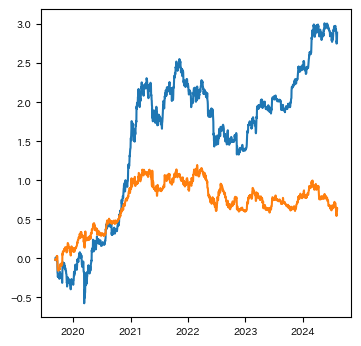

In [54]:
plt.plot(candles_1d['ret'].cumsum())
plt.plot(candles_1d_us['ret'].cumsum());
